In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import accuracy_score

from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, UniversalPerturbation, SaliencyMapMethod
from art.estimators.classification import KerasClassifier

# Set the random seeds. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Defining some constants
NUM_CLASSES = 10
BATCH_SIZE = 64

## Setting up things

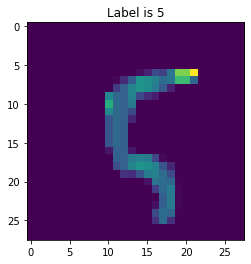

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# Plot an example image (after normalization) from the train set
plt.title('Label is {}'.format(y_train[100]))
plt.imshow(x_train[100])
plt.show()

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)

## Train CNN based model

### You need to complete the following.

In [ ]:
input_shape = x_train[0].shape

In [ ]:
# Define the CNN network architecture. 
cnn_based_model = Sequential()

# Define the intermediate layers.
cnn_based_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn_based_model.add(MaxPooling2D((2, 2), data_format='channels_first'))
cnn_based_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_based_model.add(MaxPooling2D((2, 2), data_format='channels_first'))
cnn_based_model.add(Conv2D(64, (3, 3), activation='relu'))

cnn_based_model.add(Flatten())
cnn_based_model.add(Dense(64, activation='relu'))
cnn_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
cnn_based_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 26, 26)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 13, 13)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 11, 11)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 5, 5)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 3, 3)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [ ]:
# Compile the CNN model. 
cnn_based_model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

cnn_based_classifier = KerasClassifier(model=cnn_based_model, clip_values=(0,1))
cnn_based_classifier.fit(x_train, y_train, nb_epochs=5, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = cnn_based_classifier.predict(x_test)

# Compute the accuracy on the test set.
cnn_based_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cnn_original_score = cnn_based_score

print('Test accuracy:', cnn_based_score)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0240 - accuracy: 0.9919
Epoch 2/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0180 - accuracy: 0.9939
Epoch 3/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0144 - accuracy: 0.9955
Epoch 4/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0125 - accuracy: 0.9961
Epoch 5/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0105 - accuracy: 0.9965


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Test accuracy: 0.9882


## Train ANN based model (dense layers only)

### You need to complete the following.

In [ ]:
# Define the ANN network architecture.
ann_based_model = Sequential()

# Define the intermediate layers.
ann_based_model.add(Flatten(input_shape=input_shape))
# ann_based_model.add(Dropout(0.5))
ann_based_model.add(Dense(128, activation='relu'))
ann_based_model.add(Dropout(0.5))
ann_based_model.add(Dense(32))

ann_based_model.add(Dense(NUM_CLASSES, activation='softmax'))

In [ ]:
# Compile the ANN model. 
ann_based_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [ ]:
ann_based_classifier = KerasClassifier(model=ann_based_model, clip_values=(0,1))
ann_based_classifier.fit(x_train, y_train, nb_epochs=10, batch_size=BATCH_SIZE)

# Get the predictions on the test set.
predictions = ann_based_classifier.predict(x_test)

# Compute the accuracy on the test set.
ann_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
ann_original_score = ann_score

print('Test accuracy:', ann_score)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 44us/sample - loss: 0.1122 - sparse_categorical_accuracy: 0.9649
Epoch 2/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1101 - sparse_categorical_accuracy: 0.9658
Epoch 3/10
60000/60000 [==============================] - 4s 60us/sample - loss: 0.1009 - sparse_categorical_accuracy: 0.9685
Epoch 4/10
60000/60000 [==============================] - 2s 42us/sample - loss: 0.1035 - sparse_categorical_accuracy: 0.9672
Epoch 5/10
60000/60000 [==============================] - 2s 41us/sample - loss: 0.0977 - sparse_categorical_accuracy: 0.9679
Epoch 6/10
60000/60000 [==============================] - 3s 42us/sample - loss: 0.0983 - sparse_categorical_accuracy: 0.9688
Epoch 7/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0931 - sparse_categorical_accuracy: 0.9697
Epoch 8/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.0895 - spars

## Compare the classification accuracy on the test data graphically

### You need to complete the following.

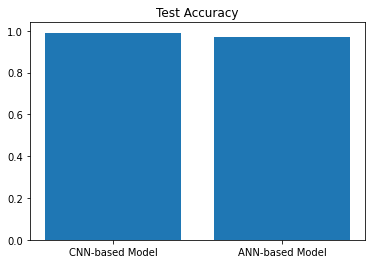

In [ ]:
X = ['CNN-based Model','ANN-based Model']
Y = [cnn_based_score, ann_score]
plt.bar(X, Y)
plt.title('Test Accuracy')
plt.show()
plt.close()

## Part 2: Generate adversarial examples using four methods

### You need to complete the following.

In [ ]:
def generate_adv_examples_FGSM(classifier, x):
    # This attack is known as the "Fast Gradient Sign Method".
    attack = FastGradientMethod(classifier)
    return attack.generate(x)

def generate_adv_examples_BasicIterativeMethod(classifier, x):
    # The Basic Iterative Method is the iterative version of FGM and FGSM.
    attack = BasicIterativeMethod(classifier)
    return attack.generate(x)

def generate_adv_examples_SaliencyMapMethod(classifier, x):
    # attack from the Jacobian-based Saliency Map Attack (Papernot et al. 2016).
    # Paper link: https://arxiv.org/abs/1511.07528
    attack = SaliencyMapMethod(classifier)
    return attack.generate(x)

def generate_adv_examples_UniversalPerturbation(classifier, x):
    attack = UniversalPerturbation(classifier)
    return attack.generate(x)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/8 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

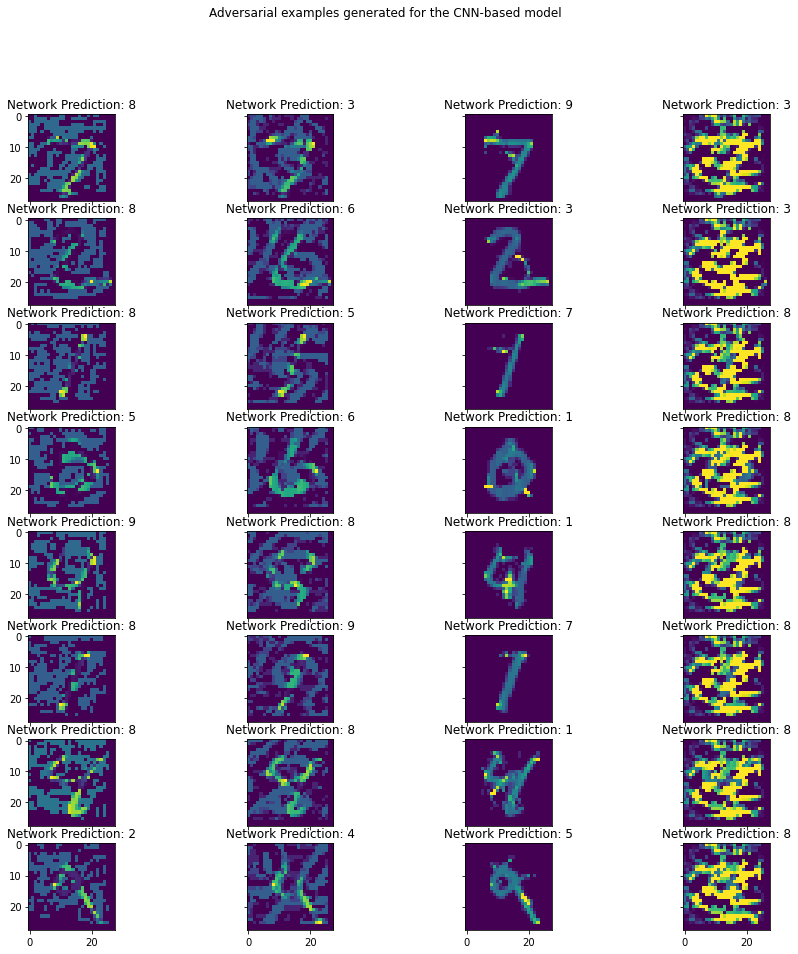

In [ ]:
# Generate examples for CNN-based model
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test[:8])
cnn_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(cnn_based_classifier, x_test[:8])
cnn_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(cnn_based_classifier, x_test[:8])
cnn_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(cnn_based_classifier, x_test[:8])

# Generate plot
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the CNN-based model')
cnn_adv_examples = [
    cnn_adv_examples_FGSM,
    cnn_adv_examples_BasicIterativeMethod,
    cnn_adv_examples_SaliencyMapMethod,
    cnn_adv_examples_UniversalPerturbation,
]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(cnn_adv_examples[j][i].squeeze())
        predictions = cnn_based_classifier.predict(np.expand_dims(cnn_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/8 [00:00<?, ?it/s]

Universal perturbation:   0%|          | 0/20 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

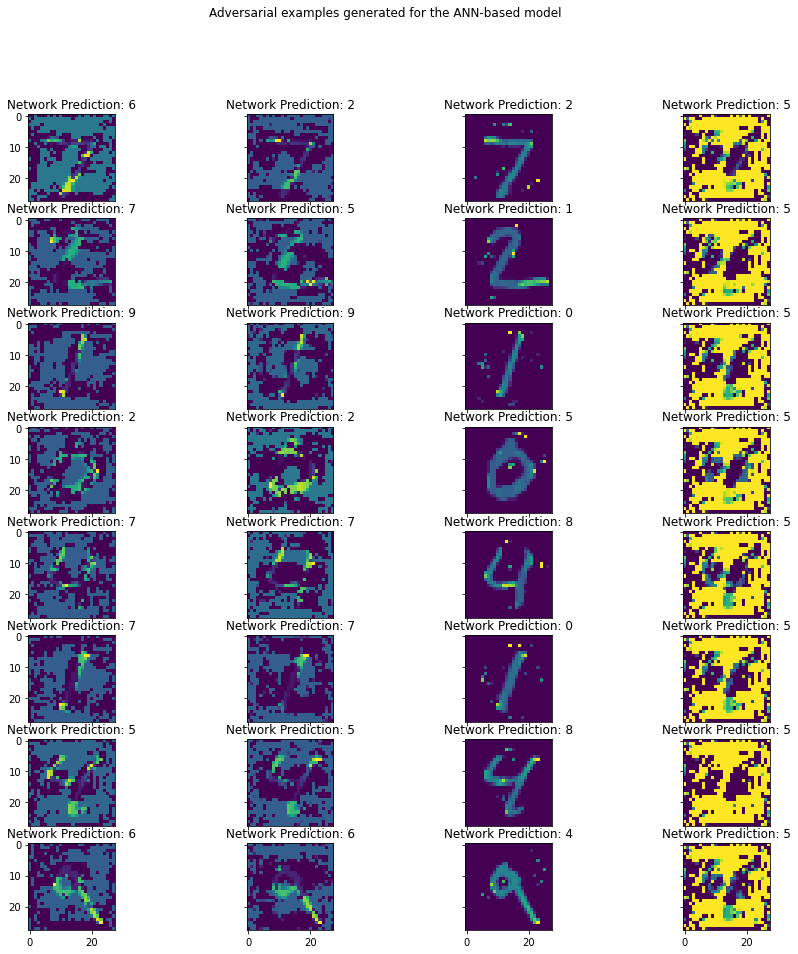

In [ ]:
# Generate examples for ANN-based model
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test[:8])
ann_adv_examples_BasicIterativeMethod = generate_adv_examples_BasicIterativeMethod(ann_based_classifier, x_test[:8])
ann_adv_examples_SaliencyMapMethod = generate_adv_examples_SaliencyMapMethod(ann_based_classifier, x_test[:8])
ann_adv_examples_UniversalPerturbation = generate_adv_examples_UniversalPerturbation(ann_based_classifier, x_test[:8])

# Generate plots
fig, ax = plt.subplots(8, 4, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle('Adversarial examples generated for the ANN-based model')
ann_adv_examples = [
    ann_adv_examples_FGSM,
    ann_adv_examples_BasicIterativeMethod,
    ann_adv_examples_SaliencyMapMethod,
    ann_adv_examples_UniversalPerturbation,
]

for i in range(8):
    for j in range(4):
        ax[i, j].imshow(ann_adv_examples[j][i].squeeze())
        predictions = ann_based_classifier.predict(np.expand_dims(ann_adv_examples[j][i], 0))
        ax[i, j].set_title('Network Prediction: {}'.format(np.argmax(predictions)))

## Part 3: Create a new test set, based entirely on the adversarial images generated previously. Test your classifiers performance on this test set.

### You need to complete the following.

In [ ]:
# We will be using the FGSM method in this part
ann_adv_examples_FGSM = generate_adv_examples_FGSM(ann_based_classifier, x_test)
cnn_adv_examples_FGSM = generate_adv_examples_FGSM(cnn_based_classifier, x_test)

In [ ]:
# Evaluate ANN-based-classifier on the newly generated adversarial test set
predictions = ann_based_classifier.predict(ann_adv_examples_FGSM)
ann_based_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
ann_adv_score = ann_based_score
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.0219


In [ ]:
# Evaluate CNN-based-classifier on the newly generated adversarial test set
predictions = cnn_based_classifier.predict(cnn_adv_examples_FGSM)
cnn_based_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cnn_adv_score = cnn_based_score
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: 0.0407


## Create a new augmented test set (original test images + adversarial images)


### You need to complete the following.

In [ ]:
print(ann_adv_examples_FGSM[0].shape)
print(x_test[0].shape)

(1, 28, 28)
(1, 28, 28)


In [ ]:
import random

# ANN-based-classifier
ann_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        ann_augmented_examples.append(ann_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        ann_augmented_examples.append(x_test[i])
        
ann_augmented_examples = np.concatenate(ann_augmented_examples, axis=0)
ann_augmented_examples = ann_augmented_examples.reshape(ann_augmented_examples.shape[0], 1, 28, 28)
# print(ann_augmented_examples.shape, x_test.shape, ann_augmented_examples[0].shape)

predictions = ann_based_classifier.predict(ann_augmented_examples)
ann_based_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
ann_augmented_score = ann_based_score
print('ANN-based Model Score: {}'.format(ann_based_score))

ANN-based Model Score: 0.4976


In [ ]:
# CNN-based-classifier
cnn_augmented_examples = []
for i in range(10000):
    
    # Select adversarial samples.
    if random.randint(0, 1) == 0:
        cnn_augmented_examples.append(cnn_adv_examples_FGSM[i])
    # Select actual samples.
    else:
        cnn_augmented_examples.append(x_test[i])

cnn_augmented_examples = np.concatenate(cnn_augmented_examples, axis=0)
cnn_augmented_examples = cnn_augmented_examples.reshape(cnn_augmented_examples.shape[0], 1, 28, 28)

predictions = cnn_based_classifier.predict(cnn_augmented_examples)
cnn_based_score = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
cnn_augmented_score = cnn_based_score
print('CNN-based Model Score: {}'.format(cnn_based_score))

CNN-based Model Score: 0.5138


## Make a single plot, wherein you compare the test accuracies of all the models, on the three types of test sets that you have

### You need to complete the following.

In [ ]:
ann_models_score = [ann_original_score, ann_augmented_score, ann_adv_score]
cnn_models_score = [cnn_original_score, cnn_augmented_score, cnn_adv_score]

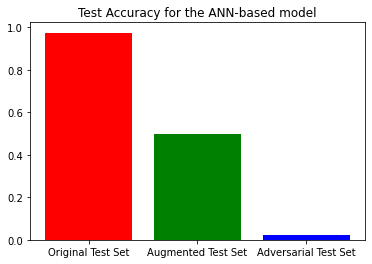

In [ ]:
# Plot for the ANN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X, ann_models_score, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the ANN-based model')
plt.show()
plt.close()

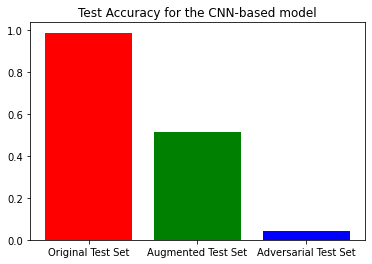

In [ ]:
# Plot for the CNN based model.
X = ['Original Test Set','Augmented Test Set', 'Adversarial Test Set']
plt.bar(X, cnn_models_score, color=['r', 'g', 'b'])
plt.title('Test Accuracy for the CNN-based model')
plt.show()
plt.close()